In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

np.random.seed(42)
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
%config InlineBackend.figure_format = 'retina'

In [3]:
pallette = {
    'Prdm12Cre+Rnase4flfl': 'tab:blue',
    'Prdm12Cre+': 'tab:green',
    'BAFCre+Rnase4flfl': 'brown',
    'BAFCre-': 'indigo',
}

In [4]:
def cal_sem(x):
    sem = stats.sem(x)
    return x.mean() - sem, x.mean() + sem

In [5]:
dfs = pd.read_excel('./behavior_new.xlsx', sheet_name=list(range(8)))

# Prdm12Cre+

## Prdm12Cre+ von-Frey

In [5]:
stats.mannwhitneyu(dfs[0].loc[(dfs[0].strain == 'Prdm12Cre+Rnase4flfl') & (dfs[0].timepoint == 'TAM_D30'), 'ipsi'],
                   dfs[0].loc[(dfs[0].strain == 'Prdm12Cre+') & (dfs[0].timepoint == 'TAM_D30'), 'ipsi'])

MannwhitneyuResult(statistic=14.5, pvalue=0.6109295601849647)

In [ ]:
test_tam = pd.DataFrame(columns=['Time','p'])
for t in dfs[0].timepoint.unique():
    res = stats.mannwhitneyu(dfs[0].loc[lambda x: (x.strain == 'Prdm12Cre+') & (x.timepoint == t), 'ipsi'],
                             dfs[0].loc[lambda x: (x.strain != 'Prdm12Cre+') & (x.timepoint == t), 'ipsi'])
    test_tam.loc[len(test_tam)] = [t, res.pvalue]

test_tam['p_adj'] = multipletests(test_tam.p, method='fdr_bh')[1]
test_tam

,Time,p,p_adj
0,Baseline,0.880328,0.880328
1,TAM_D7,0.004922,0.019688
2,TAM_D17,0.018311,0.036621
3,TAM_D30,0.610930,0.814573


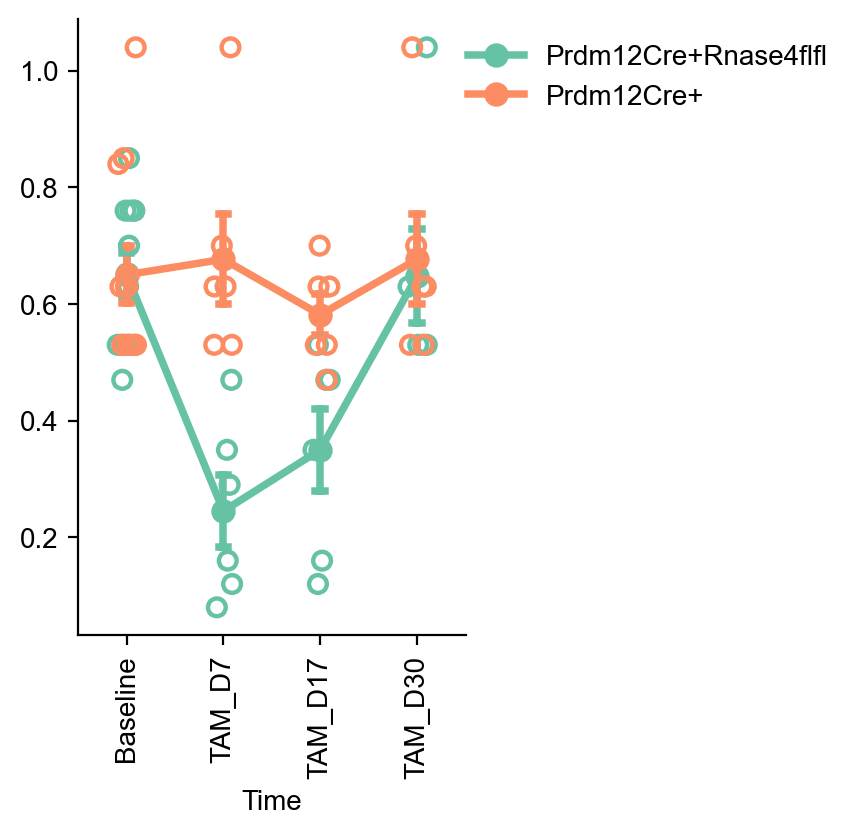

In [13]:
fig, ax = plt.subplots(figsize=(2.5, 4))
sns.pointplot(data=dfs[0], x='timepoint', y='ipsi', hue='strain', errorbar=cal_sem, ax=ax, capsize=0.1, palette='Set2')
sns.stripplot(data=dfs[0], x='timepoint', y='ipsi', hue='strain', ax=ax, dodge=False, palette='Set2', marker='$\circ$', size=8, legend=False)
ax.set_xlabel('Time')
ax.set_ylabel('')
ax.xaxis.set_tick_params(rotation=90)
ax.legend_.set_loc('upper right')
ax.legend_.set_frame_on(False)
ax.legend_.set_title('')
ax.legend_.set_bbox_to_anchor((2,1))
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
fig.savefig('./figures/07_prdm12cre_von_TAM.pdf', bbox_inches='tight', dpi=300)

In [8]:
stats.mannwhitneyu(dfs[1].loc[(dfs[1].strain == 'Prdm12Cre+Rnase4flfl') & (dfs[1].timepoint == 'Inj_D14'), 'ipsi'],
                   dfs[1].loc[(dfs[1].strain == 'Prdm12Cre+') & (dfs[1].timepoint == 'Inj_D14'), 'ipsi'], nan_policy='omit')

MannwhitneyuResult(statistic=0.0, pvalue=0.007407833711689612)

In [205]:
df_plot = pd.concat([dfs[0].loc[lambda x: x.timepoint == 'Baseline'],dfs[1]]).reset_index(drop=True)

In [206]:
# use Wilcoxon signed-rank test to compare the measurements on the same samples
print('Inj_D14 compared to Baseline')
for s in df_plot.strain.unique():
    res = stats.wilcoxon(df_plot.loc[(df_plot.strain == s) & (df_plot.timepoint == 'Baseline'), 'ipsi'].sample(6, random_state=42),
                         df_plot.loc[(df_plot.strain == s) & (df_plot.timepoint == 'Inj_D14'), 'ipsi'], nan_policy='omit')
    print(f"{s}: {res.pvalue:.3f} - {'Significant' if res.pvalue < 0.05 else 'Not Significant'}")

Inj_D14 compared to Baseline
Prdm12Cre+Rnase4flfl: 0.125 - Not Significant
Prdm12Cre+: 0.031 - Significant


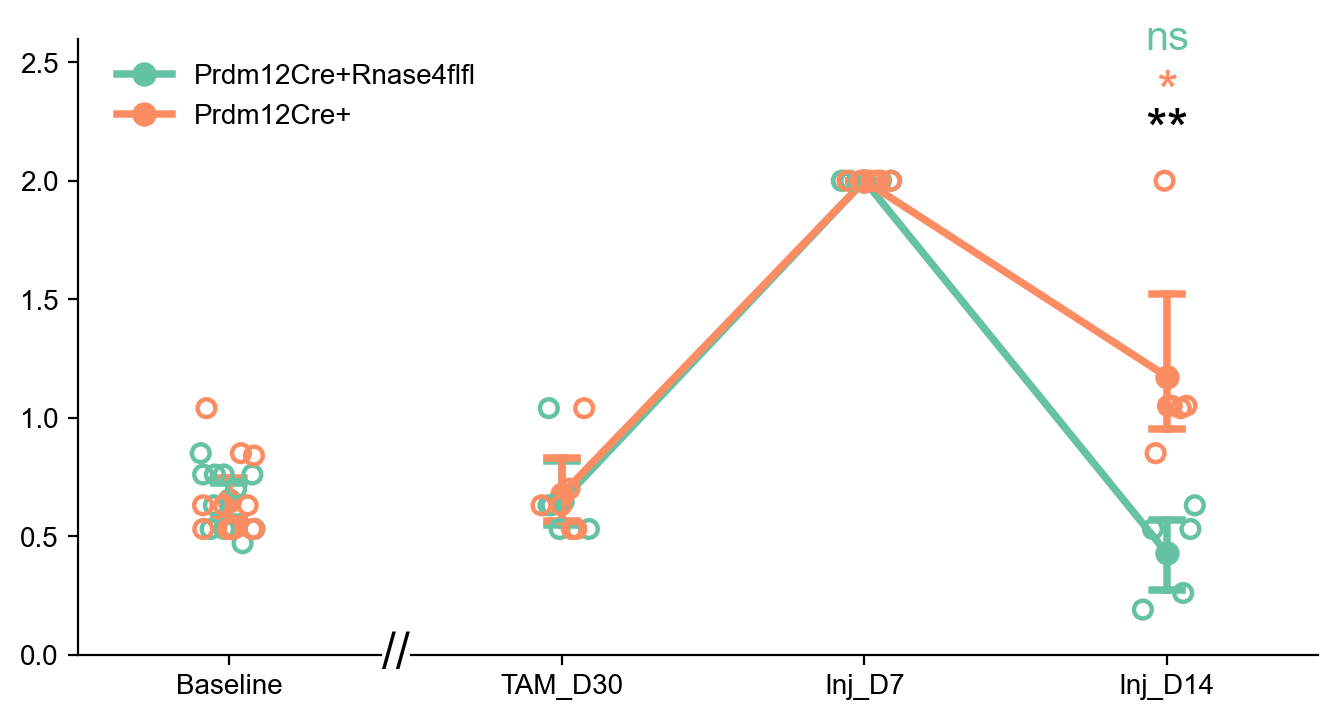

In [214]:
# Create two subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 3], 'wspace': 0.05})

# First plot: Baseline only
sns.pointplot(data=df_plot[df_plot['timepoint'] == 'Baseline'], x='timepoint', y='ipsi', hue='strain', ax=ax1, capsize=0.1, palette='Set2', legend=False)
sns.stripplot(data=df_plot[df_plot['timepoint'] == 'Baseline'], x='timepoint', y='ipsi', hue='strain', ax=ax1, dodge=False, palette='Set2', marker='$\circ$', size=8, legend=False)

# Second plot: Rest of the time points
sns.pointplot(data=df_plot[df_plot['timepoint'] != 'Baseline'], x='timepoint', y='ipsi', hue='strain', ax=ax2, capsize=0.1, palette='Set2')
sns.stripplot(data=df_plot[df_plot['timepoint'] != 'Baseline'], x='timepoint', y='ipsi', hue='strain', ax=ax2, dodge=False, palette='Set2', marker='$\circ$', size=8, legend=False)

# Set labels and limits
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('')
ax2.set_ylabel('')

max_val = df_plot.ipsi.max()
ax1.set_ylim(0, max_val + max_val * 0.3)
ax2.set_ylim(0, max_val + max_val * 0.3)

# Remove spines to create the break effect
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False)

# Remove unnecessary legend
ax2.legend_.set_bbox_to_anchor((0.1, 1))
ax2.legend_.set_frame_on(False)
ax2.legend_.set_title('')
for s in ['top', 'right']:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

# Add diagonal lines to indicate the break in the axis
ax1.text(1.05, 0, '//', ha='center', va='center', transform=ax1.transAxes, fontsize=18)

# Add a star to indicate the significance
ax2.text(ax2.get_xlim()[-1]-0.5, max_val+max_val*.1, '**', ha='center', va='center', fontsize=20)
ax2.text(ax2.get_xlim()[-1]-0.5, max_val+max_val*.18, '*', ha='center', va='center', fontsize=20, color=ax2.lines[-1].get_color())
ax2.text(ax2.get_xlim()[-1]-0.5, max_val+max_val*.3, 'ns', ha='center', va='center', fontsize=15, color=ax2.lines[0].get_color())
fig.savefig('./figures/07_prdm12cre_von.pdf', bbox_inches='tight')

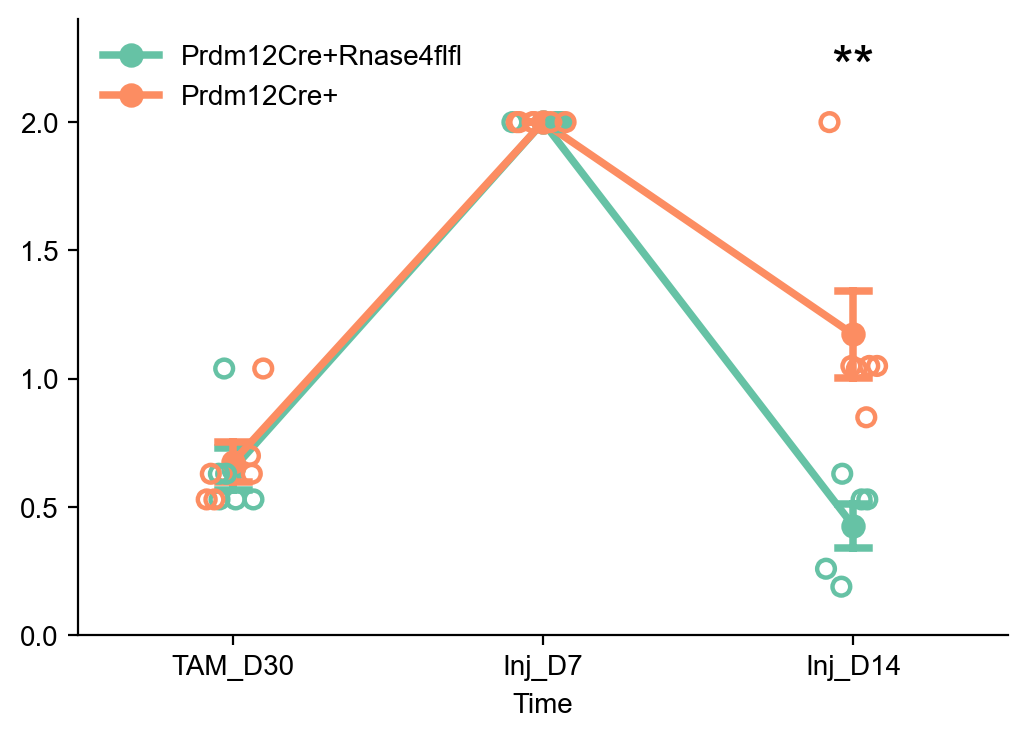

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data=dfs[1], x='timepoint', y='ipsi', hue='strain', errorbar=cal_sem, ax=ax, capsize=0.1, palette='Set2')
sns.stripplot(data=dfs[1], x='timepoint', y='ipsi', hue='strain', ax=ax, dodge=False, palette='Set2', marker='$\circ$', size=8, legend=False)
ax.set_xlabel('Time')
ax.set_ylabel('')

max_val = dfs[1].ipsi.max()
ax.set_ylim(0, max_val + max_val*.2)
ax.text(ax.get_xlim()[-1]-0.5, max_val+max_val*.1, '**', ha='center', va='center', fontsize=20)

ax.legend_.set_loc('upper left')
ax.legend_.set_frame_on(False)
ax.legend_.set_title('')

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

## Prdm12Cre+ Hargreaves

In [10]:
stats.mannwhitneyu(dfs[2].loc[(dfs[2].strain == 'Prdm12Cre+Rnase4flfl') & (dfs[2].timepoint == 'TAM_D30'), 'ipsi'],
                   dfs[2].loc[(dfs[2].strain == 'Prdm12Cre+') & (dfs[2].timepoint == 'TAM_D30'), 'ipsi'], nan_policy='omit')

MannwhitneyuResult(statistic=26.0, pvalue=0.22649054028251026)

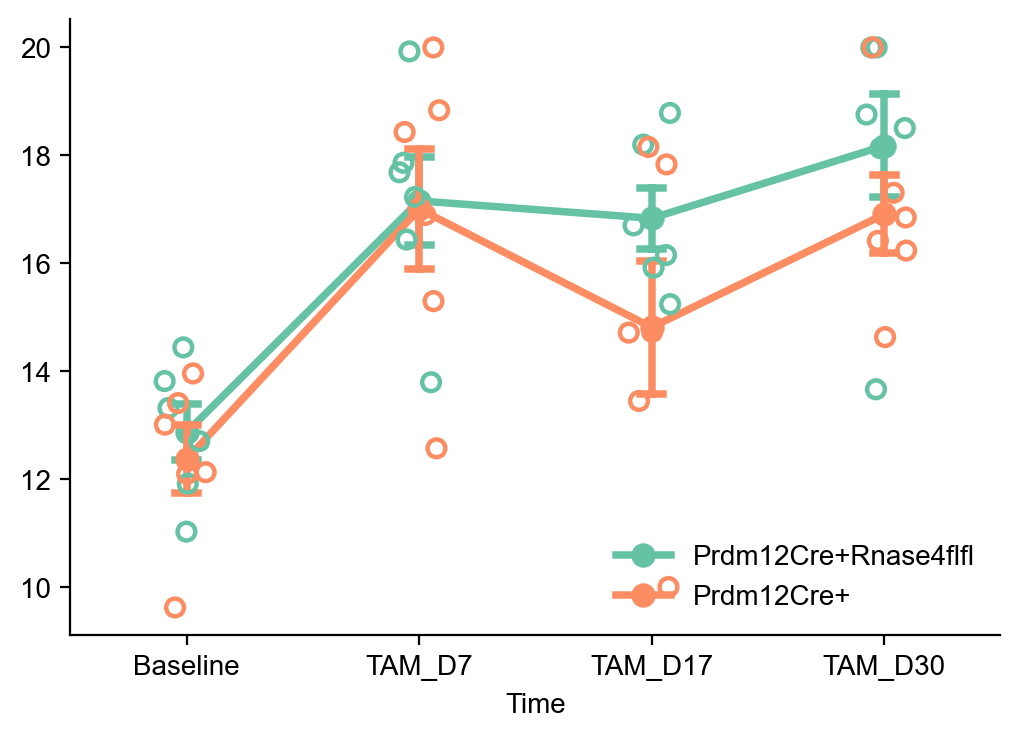

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data=dfs[2], x='timepoint', y='ipsi', hue='strain', errorbar=cal_sem, ax=ax, capsize=0.1, palette='Set2')
sns.stripplot(data=dfs[2], x='timepoint', y='ipsi', hue='strain', ax=ax, dodge=False, palette='Set2', marker='$\circ$', size=8, legend=False)
ax.set_xlabel('Time')
ax.set_ylabel('')
ax.legend_.set_loc('lower right')
ax.legend_.set_frame_on(False)
ax.legend_.set_title('')
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    
# Add diagonal lines to indicate the break in the axis
ax1.text(1.05, 0, '//', ha='center', va='center', transform=ax1.transAxes, fontsize=18)

# Add a star to indicate the significance
ax2.text(ax2.get_xlim()[-1]-0.5, max_val+max_val*.1, '**', ha='center', va='center', fontsize=20)
ax2.text(ax2.get_xlim()[-1]-0.5, max_val+max_val*.18, '*', ha='center', va='center', fontsize=20, color=ax2.lines[-1].get_color())

In [12]:
stats.mannwhitneyu(dfs[3].loc[(dfs[3].strain == 'Prdm12Cre+Rnase4flfl') & (dfs[3].timepoint == 'Inj_D14'), 'ipsi'],
                   dfs[3].loc[(dfs[3].strain == 'Prdm12Cre+') & (dfs[3].timepoint == 'Inj_D14'), 'ipsi'], nan_policy='omit')

MannwhitneyuResult(statistic=30.0, pvalue=0.004329004329004329)

In [215]:
df_plot = pd.concat([dfs[2].loc[lambda x: x.timepoint == 'Baseline'],dfs[3]]).reset_index(drop=True)

In [216]:
print('Inj_D14 compared to Baseline')
for s in df_plot.strain.unique():
    res = stats.wilcoxon(df_plot.loc[(df_plot.strain == s) & (df_plot.timepoint == 'Baseline'), 'ipsi'],
                         df_plot.loc[(df_plot.strain == s) & (df_plot.timepoint == 'Inj_D14'), 'ipsi'], nan_policy='omit')
    print(f"{s}: {res.pvalue:.3f} - {'Significant' if res.pvalue < 0.05 else 'Not Significant'}")

Inj_D14 compared to Baseline
Prdm12Cre+Rnase4flfl: 0.062 - Not Significant
Prdm12Cre+: 0.031 - Significant


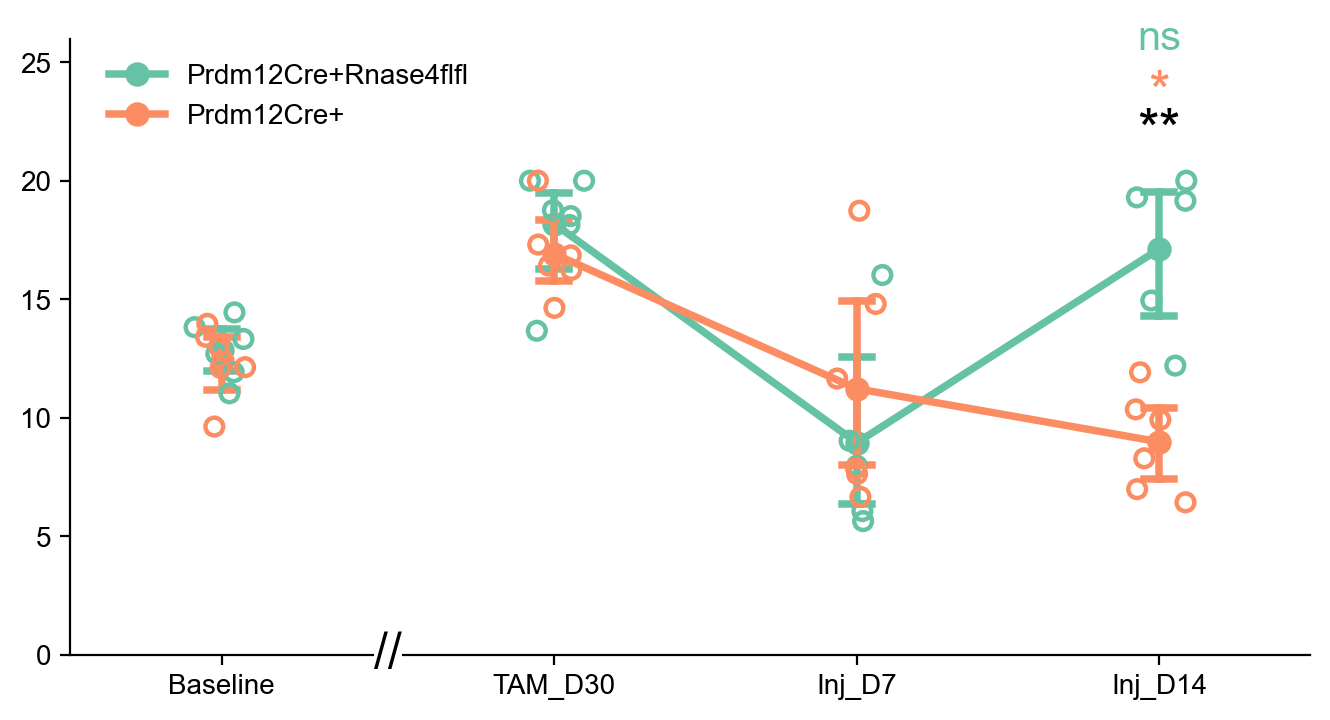

In [217]:
# Create two subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 3], 'wspace': 0.05})

# First plot: Baseline only
sns.pointplot(data=df_plot[df_plot['timepoint'] == 'Baseline'], x='timepoint', y='ipsi', hue='strain', ax=ax1, capsize=0.1, palette='Set2', legend=False)
sns.stripplot(data=df_plot[df_plot['timepoint'] == 'Baseline'], x='timepoint', y='ipsi', hue='strain', ax=ax1, dodge=False, palette='Set2', marker='$\circ$', size=8, legend=False)

# Second plot: Rest of the time points
sns.pointplot(data=df_plot[df_plot['timepoint'] != 'Baseline'], x='timepoint', y='ipsi', hue='strain', ax=ax2, capsize=0.1, palette='Set2')
sns.stripplot(data=df_plot[df_plot['timepoint'] != 'Baseline'], x='timepoint', y='ipsi', hue='strain', ax=ax2, dodge=False, palette='Set2', marker='$\circ$', size=8, legend=False)

# Set labels and limits
# ax1.set_xlabel('Time')
# ax2.set_xlabel('Time')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('')
ax2.set_ylabel('')

max_val = df_plot.ipsi.max()
ax1.set_ylim(0, max_val + max_val * 0.3)
ax2.set_ylim(0, max_val + max_val * 0.3)

# Remove spines to create the break effect
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False)

# Remove unnecessary legend
ax2.legend_.set_bbox_to_anchor((0.1, 1))
ax2.legend_.set_frame_on(False)
ax2.legend_.set_title('')
for s in ['top', 'right']:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

# Add diagonal lines to indicate the break in the axis
ax1.text(1.05, 0, '//', ha='center', va='center', transform=ax1.transAxes, fontsize=18)

# Add a star to indicate the significance
ax2.text(ax2.get_xlim()[-1]-0.5, max_val+max_val*.1, '**', ha='center', va='center', fontsize=20)
ax2.text(ax2.get_xlim()[-1]-0.5, max_val+max_val*.18, '*', ha='center', va='center', fontsize=20, color=ax2.lines[-1].get_color())
ax2.text(ax2.get_xlim()[-1]-0.5, max_val+max_val*.3, 'ns', ha='center', va='center', fontsize=15, color=ax2.lines[0].get_color())
fig.savefig('./figures/07_prdm12cre_har.pdf', bbox_inches='tight')


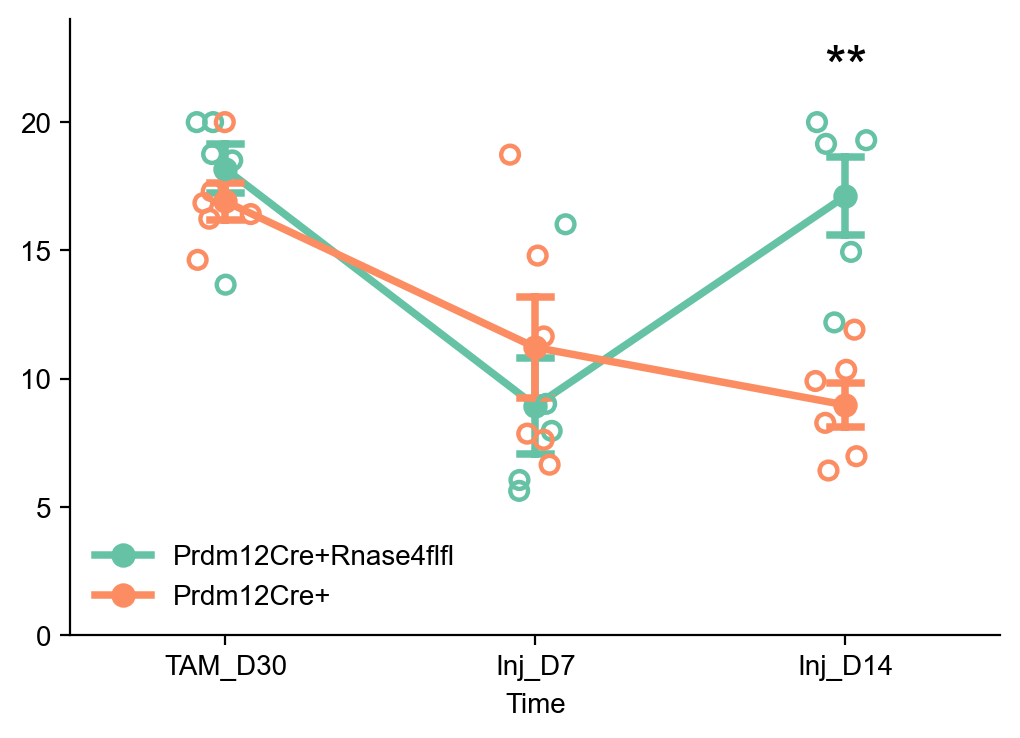

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data=dfs[3], x='timepoint', y='ipsi', hue='strain', errorbar=cal_sem, ax=ax, capsize=0.1, palette='Set2')
sns.stripplot(data=dfs[3], x='timepoint', y='ipsi', hue='strain', ax=ax, dodge=False, palette='Set2', marker='$\circ$', size=8, legend=False)
ax.set_xlabel('Time')
ax.set_ylabel('')

max_val = dfs[3].ipsi.max()
ax.set_ylim(0, max_val + max_val*.2)
ax.text(ax.get_xlim()[-1]-0.5, max_val+max_val*.1, '**', ha='center', va='center', fontsize=20)

ax.legend_.set_loc('lower left')
ax.legend_.set_frame_on(False)
ax.legend_.set_title('')

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

In [14]:
stats.mannwhitneyu(dfs[5].loc[(dfs[5].strain == 'BAFCre+Rnase4flfl'), 'ipsi'],
                   dfs[5].loc[(dfs[5].strain == 'BAFCre-'), 'ipsi'], nan_policy='omit')

MannwhitneyuResult(statistic=413.0, pvalue=0.5760865552684037)

In [17]:
har_bar = dfs[2].loc[lambda x: x.timepoint.isin(['Baseline','TAM_D30'])].reset_index(drop=True)
har_bar

,id,sex,strain,timepoint,contra,ipsi
0,629001,M,Prdm12Cre+Rnase4flfl,Baseline,15.084286,12.705714
1,632229,M,Prdm12Cre+Rnase4flfl,Baseline,10.172857,11.028571
2,637610,M,Prdm12Cre+Rnase4flfl,Baseline,11.991429,11.917143
3,606007,F,Prdm12Cre+Rnase4flfl,Baseline,11.574286,14.442857
4,631472,F,Prdm12Cre+Rnase4flfl,Baseline,12.442857,13.818571
5,634632,F,Prdm12Cre+Rnase4flfl,Baseline,11.552857,13.320000
6,629001,M,Prdm12Cre+Rnase4flfl,TAM_D30,13.240000,18.133333
7,632229,M,Prdm12Cre+Rnase4flfl,TAM_D30,19.560000,20.000000
8,637610,M,Prdm12Cre+Rnase4flfl,TAM_D30,19.886667,18.756667
9,606007,F,Prdm12Cre+Rnase4flfl,TAM_D30,18.503333,20.000000


In [52]:
har_bar['ST'] = har_bar.strain.astype(str) + '_' + har_bar.timepoint.astype(str)

In [53]:
test_harbar = pd.DataFrame(columns=['group1','group2','p'])
for i in har_bar.ST.unique():
    for j in har_bar.ST.unique()[1:]:
        res = stats.ttest_ind(har_bar[har_bar.ST == i]['ipsi'], har_bar[har_bar.ST == j]['ipsi'])
        test_harbar.loc[len(test_harbar)] = [i, j, res.pvalue]
from statsmodels.stats.multitest import multipletests
test_harbar = test_harbar.loc[lambda x: x.group1 != x.group2]
test_harbar = test_harbar[~test_harbar[['group1','group2']].apply(frozenset, axis=1).duplicated()].reset_index(drop=True)
test_harbar['p_adj'] = multipletests(test_harbar.p, method='fdr_bh')[1]
test_harbar

,group1,group2,p,p_adj
0,Prdm12Cre+Rnase4flfl_Baseline,Prdm12Cre+Rnase4flfl_TAM_D30,0.000634,0.001549
1,Prdm12Cre+Rnase4flfl_Baseline,Prdm12Cre+_Baseline,0.550352,0.550352
2,Prdm12Cre+Rnase4flfl_Baseline,Prdm12Cre+_TAM_D30,0.001042,0.001563
3,Prdm12Cre+Rnase4flfl_TAM_D30,Prdm12Cre+_Baseline,0.000476,0.001549
4,Prdm12Cre+Rnase4flfl_TAM_D30,Prdm12Cre+_TAM_D30,0.313868,0.376641
5,Prdm12Cre+_Baseline,Prdm12Cre+_TAM_D30,0.000774,0.001549


In [32]:
pal = dict(zip(['Prdm12Cre+Rnase4flfl','Prdm12Cre+'],list(sns.color_palette('Set2',2).as_hex())))

In [33]:
har_bar.strain = har_bar.strain.astype('category')

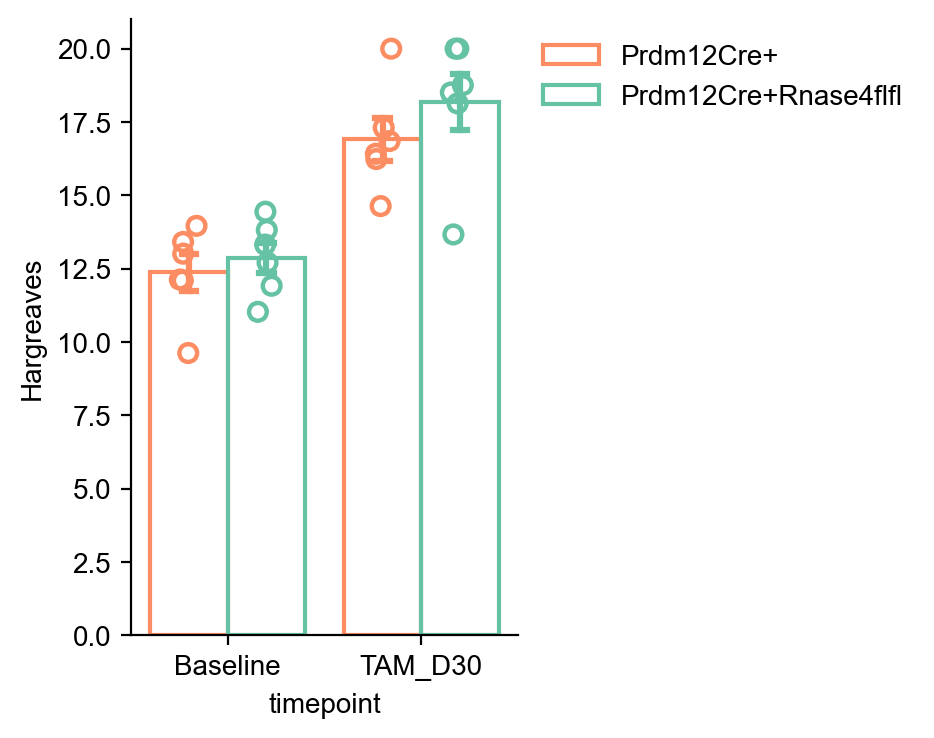

In [50]:
fig, ax = plt.subplots(figsize=(2.5, 4))
sns.barplot(data=har_bar, x='timepoint', y='ipsi', hue='strain', errorbar=cal_sem, ax=ax, capsize=0.15, palette=pal, fill=False, linewidth=1.5)
sns.stripplot(data=har_bar, x='timepoint', y='ipsi', hue='strain', ax=ax, dodge=True, palette=pal, marker='$\circ$', size=8, legend=False)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
ax.legend_.set_frame_on(False)
ax.legend_.set_title('')
ax.legend_.set_bbox_to_anchor((1,1))
ax.set_ylabel('Hargreaves')
fig.savefig('./figures/07_prdm12cre_har_TAM_bar.pdf', bbox_inches='tight', dpi=300)

# BAFCre

## BAFCre von-Frey

In [10]:
pallette = {
    'Prdm12Cre+Rnase4flfl': 'tab:blue',
    'Prdm12Cre+': 'tab:green',
    'BAFCre+Rnase4flfl': '#7fc97f',
    'BAFCre-': '#ccbfdd',
}

In [8]:
dfs[4].strain = dfs[4].strain.astype('category').cat.reorder_categories(['BAFCre-', 'BAFCre+Rnase4flfl'])

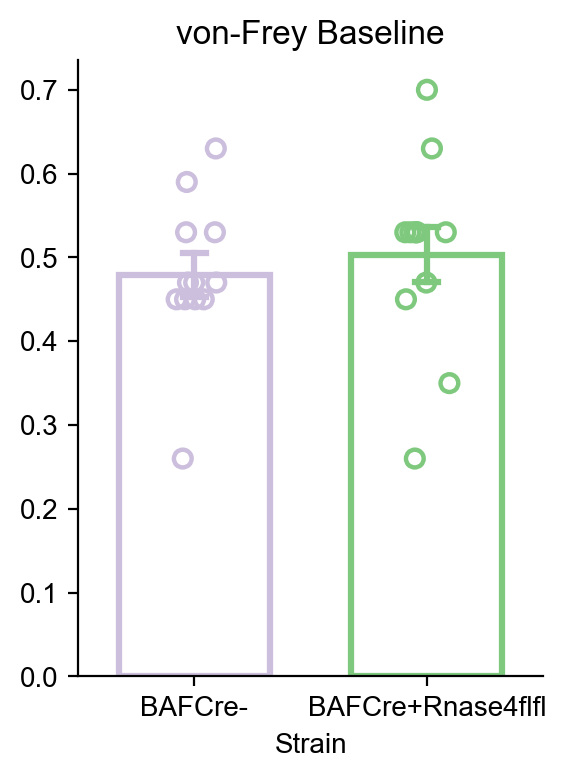

In [18]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.barplot(data=dfs[4], x='strain', y='ipsi', hue='strain', errorbar=cal_sem, ax=ax, capsize=0.1, palette=pallette, fill=False, width=0.65)
sns.stripplot(data=dfs[4], x='strain', y='ipsi', hue='strain', ax=ax, dodge=False, palette=pallette, marker='$\circ$', size=8, legend=False)
ax.set_xlabel('Strain')
ax.set_ylabel('')
ax.set_title('von-Frey Baseline')
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
fig.savefig('./figures/07_bafcre_von_bar.pdf', bbox_inches='tight')

In [16]:
stats.mannwhitneyu(dfs[5].loc[(dfs[5].strain == 'BAFCre+Rnase4flfl') & (dfs[5].timepoint == 'Inj_D14'), 'ipsi'],
                   dfs[5].loc[(dfs[5].strain == 'BAFCre-') & (dfs[5].timepoint == 'Inj_D14'), 'ipsi'], nan_policy='omit')

MannwhitneyuResult(statistic=4.5, pvalue=0.03637858037213116)

In [17]:
stats.mannwhitneyu(dfs[5].loc[(dfs[5].strain == 'BAFCre+Rnase4flfl') & (dfs[5].timepoint == 'Inj_D14'), 'ipsi'],
                   dfs[5].loc[(dfs[5].strain == 'BAFCre+Rnase4flfl') & (dfs[5].timepoint == 'Baseline'), 'ipsi'], nan_policy='omit')

MannwhitneyuResult(statistic=26.0, pvalue=0.3640191901265405)

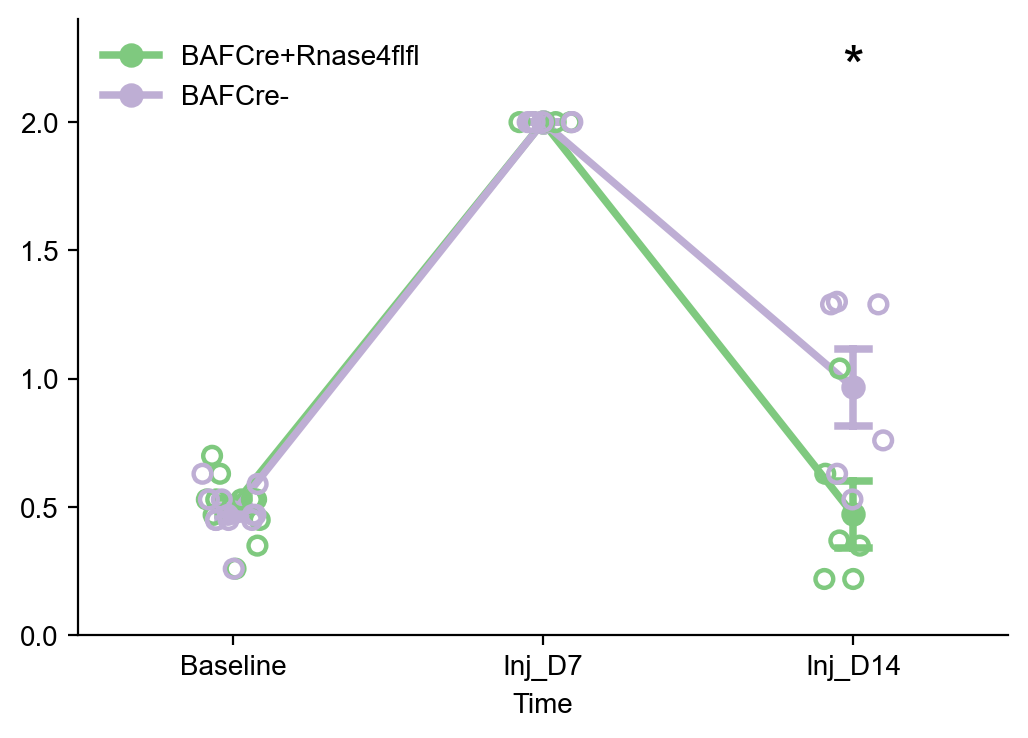

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data=dfs[5].loc[lambda x: x.timepoint != 'Inj_D3'], x='timepoint', y='ipsi', hue='strain', errorbar=cal_sem, ax=ax, capsize=0.1, palette='Accent')
sns.stripplot(data=dfs[5].loc[lambda x: x.timepoint != 'Inj_D3'], x='timepoint', y='ipsi', hue='strain', ax=ax, dodge=False, palette='Accent', marker='$\circ$', size=8, legend=False)
ax.set_xlabel('Time')
ax.set_ylabel('')

max_val = dfs[5].ipsi.max()
ax.set_ylim(0, max_val + max_val*.2)
ax.text(ax.get_xlim()[-1]-0.5, max_val+max_val*.1, '*', ha='center', va='center', fontsize=20)

ax.legend_.set_loc('upper left')
ax.legend_.set_frame_on(False)
ax.legend_.set_title('')
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
fig.savefig('./figures/07_bafcre_von.pdf', bbox_inches='tight')

## BAFCre Hargreaves

In [19]:
stats.mannwhitneyu(dfs[6].loc[(dfs[6].strain == 'BAFCre+Rnase4flfl'), 'ipsi'],
                   dfs[6].loc[(dfs[6].strain == 'BAFCre-'), 'ipsi'], nan_policy='omit')

MannwhitneyuResult(statistic=23.0, pvalue=0.48484848484848486)

In [15]:
dfs[6].strain = dfs[6].strain.astype('category').cat.reorder_categories(['BAFCre-', 'BAFCre+Rnase4flfl'])

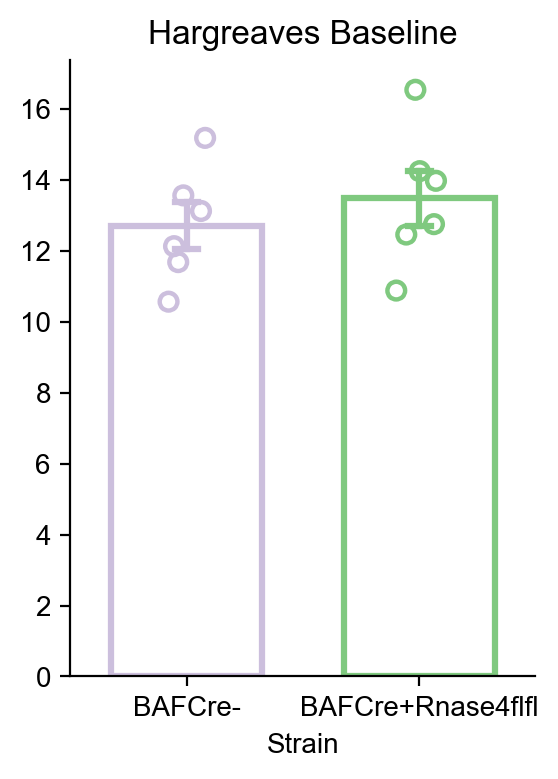

In [17]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.barplot(data=dfs[6], x='strain', y='ipsi', hue='strain', errorbar=cal_sem, ax=ax, capsize=0.1, palette=pallette, fill=False, width=0.65)
sns.stripplot(data=dfs[6], x='strain', y='ipsi', hue='strain', ax=ax, dodge=False, palette=pallette, marker='$\circ$', size=8, legend=False)
ax.set_xlabel('Strain')
ax.set_ylabel('')
ax.set_title('Hargreaves Baseline')
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
fig.savefig('./figures/07_bafcre_har_bar.pdf', bbox_inches='tight')

In [21]:
stats.mannwhitneyu(dfs[7].loc[(dfs[7].strain == 'BAFCre+Rnase4flfl') & (dfs[7].timepoint == 'Inj_D14'), 'ipsi'],
                   dfs[7].loc[(dfs[7].strain == 'BAFCre-') & (dfs[7].timepoint == 'Inj_D14'), 'ipsi'], nan_policy='omit')

MannwhitneyuResult(statistic=10.0, pvalue=0.24025974025974026)

In [22]:
stats.mannwhitneyu(dfs[7].loc[(dfs[7].strain == 'BAFCre+Rnase4flfl') & (dfs[7].timepoint == 'Inj_D14'), 'ipsi'],
                   dfs[7].loc[(dfs[7].strain == 'BAFCre+Rnase4flfl') & (dfs[7].timepoint == 'Baseline'), 'ipsi'], nan_policy='omit')

MannwhitneyuResult(statistic=6.0, pvalue=0.06493506493506493)

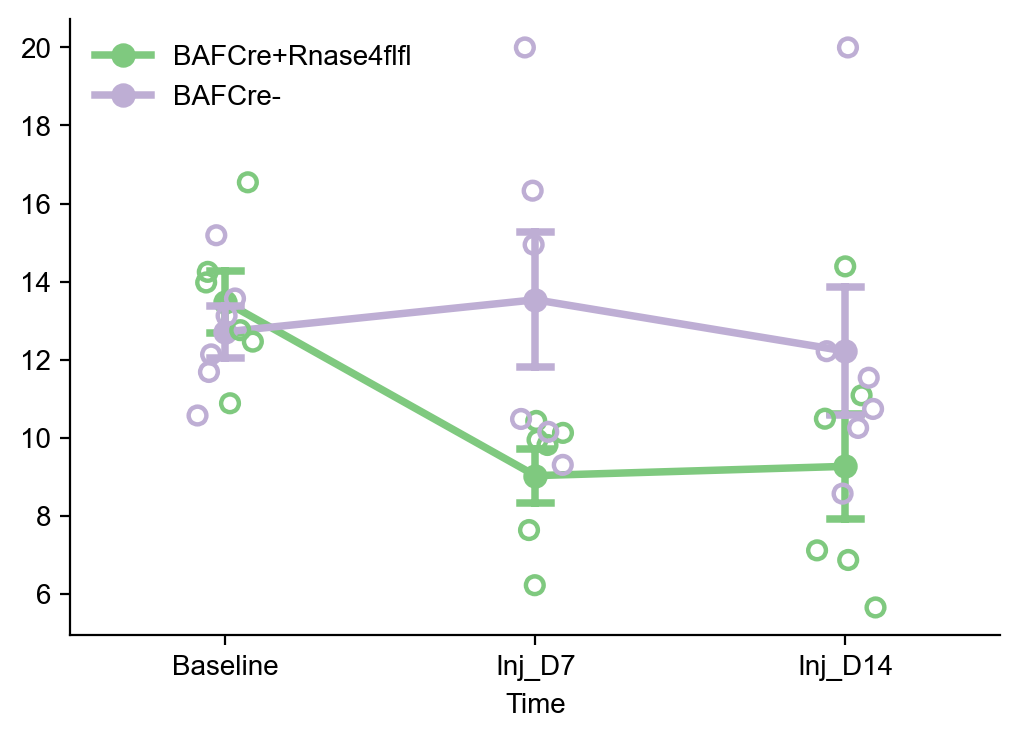

In [220]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data=dfs[7], x='timepoint', y='ipsi', hue='strain', errorbar=cal_sem, ax=ax, capsize=0.1, palette='Accent')
sns.stripplot(data=dfs[7], x='timepoint', y='ipsi', hue='strain', ax=ax, dodge=False, palette='Accent', marker='$\circ$', size=8, legend=False)
ax.set_xlabel('Time')
ax.set_ylabel('')
ax.legend_.set_loc('upper left')
ax.legend_.set_frame_on(False)
ax.legend_.set_title('')
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
fig.savefig('./figures/07_bafcre_har.pdf', bbox_inches='tight')